<a href="https://colab.research.google.com/github/WT-sudoku/Time-Series-Financial-Modelling-/blob/main/AIB552_Deep_Learning_%26_Neural_Networks_Group_based_Assignment_July_2025_Semester_Group_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AIB552_GBA_JULY2025_GROUP_01

# Table of Contents (Cell 1):
	•	1. System setup
	•	Check GPU availability (Cell 2 → Code Cell 3)
	•	Enable & read from Drive (Cell 4)

	•	2. Data ingestion
	•	Load the dataset (Cell 6 → Code Cell 7)

	•	3. Baseline GRU pipeline (Business-commented)
	•	Main Source Code (overview) (Cell 8)
	•	Business-Commented GRU Baseline — One-Day-Ahead High (Cell 9 → Code Cell 10)

	•	4. GRU fine-tuning (Random Search)
	•	Stand-alone GRU Fine-Tuning (Random Search) (Cell 11 → Code Cell 12)
	•	Fine-tuning metrics performance evaluation (Cell 13)
	•	Diebold–Mariano (DM) test for fine-tuning results (Cell 15 → Code Cells 16–17)

	•	5. Areas for improvement & proposed methodology
	•	Findings from main code & fine-tuning outputs (Cell 18–19)
	•	Note: runs even without optional exogenous CSVs (Cell 19)

	•	6. Upper-band GRU (Quantile) pipeline
	•	Pipeline overview (τ=0.90, Close→High ratio, exogenous features, α-blend) (Cell 20 → Code Cell 21)
	•	Diebold–Mariano (DM) test for upper-band pipeline (Cell 22 → Code Cells 23–24)
  
	•	7. Business insights & storytelling
	•	Translate forecasting outputs to business-grade insights (visuals & narrative) (Cell 25 → Code Cell 26)





# Check GPU availability

In [ ]:
import torch

# Check if GPU is available
print("GPU available:", torch.cuda.is_available())

# Show GPU name
if torch.cuda.is_available():
    print("GPU name:", torch.cuda.get_device_name(0))

GPU available: False


# Enable and Read the content from Drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load the Dataset

In [ ]:
import pandas as pd

# URL of the raw CSV file on drive
# Replace this with your actual file path
CSV_PATH = "/content/drive/MyDrive/stock_history_downloaded.csv"

# Read directly into a pandas DataFrame
df = pd.read_csv(CSV_PATH)

# Optionally, display a preview
df.head()
print(df.shape)

# Alternatively, Save the DataFrame to a local CSV file
# df.to_csv("stock_history_downloaded.csv", index=False)

(3872, 8)


# Main Source Code: Business-Commented GRU Baseline — One-Day-Ahead High

* 1. We benchmark a GRU model against a strong persistence baseline and deploy a risk-aware blended forecast. The blend weight α is selected on a validation period to minimize MAE, ensuring we only depart from persistence when the GRU demonstrably adds value.

* 2. Thus, the objective is not to always beat naïve with a pure GRU, but to deliver the best of both in production while controlling downside risk.”

	•	0. Title & Business Framing
	•	Objective, context, problem statement, model comparison & blend rationale

	•	1. Imports (with business purposes)

	•	2. Configuration (cost/quality knobs)
	•	Data paths, date column, train/validation split, GRU hyperparameters, reproducibility seeds

	•	3. Data Ingestion & Cleaning
	•	Read OHLCV CSV, drop vendor extras, sort by time, schema validation

	•	4. Feature Engineering (trader-intuitive signals)
	•	OHLCV base features
	•	prev_close, ATR(14) / true range, range_norm, gap_open
	•	Moving averages (ma5, ma20, ma_ratio)
	•	Log returns (ret_h, ret_c) & realized vol (rvol10)
	•	Calendar effects (dow_sin, dow_cos)

	•	5. Target Construction
	•	Next-day Δlog(High) and merge with features

	•	6. Time Split
	•	Train (≤2020), Validation (last 20% of train), Test (≥2021); define train_core, val_hold

	•	7. Scaling (leakage-safe)
	•	Fit scalers on train_core only; scale_block helper; create X_train_core, X_val_hold, X_test

	•	8. Windowing for Sequences
	•	make_windows to build [N, n_steps, F] tensors for Train / Val (with context) / Test

	•	9. GRU Model Definition (robust loss)
	•	Compact GRU(64) → Dense(1); Adam; Huber loss; MAE metric

	•	10. Training Safeguards & Fit
	•	EarlyStopping, ReduceLROnPlateau; model.fit(...) on Train with Val monitoring

	•	11. One-Step Mapping Helpers (level reconstruction)
	•	one_step_levels (model to price level), naive_levels (persistence baseline)

	•	12. Validation Blending (risk-aware)
	•	Predict on Val, invert scaling, construct level forecasts, grid search α minimizing MAE

	•	13. Test-Time Forecasts
	•	Predict Δlog(High) on Test, map to levels: Model, Naive, and Blended series

	•	14. Metrics & Business Reporting
	•	series_metrics: RMSE, MAE, MAPE, Skill vs Naive, MASE, Directional Accuracy
	•	Print blocks for MODEL and BLEND

	•	15. Visual Diagnostics
	•	Plot Actual vs Naive vs Model vs Blend with readable styling and annotations

	•	16. Notes & Assumptions (optional)

	•	Causality/leakage guards, baseline rationale, how the desk would consume outputs

Epoch 1/60
90/90 ━━━━━━━━━━━━━━━━━━━━ 15s 71ms/step - loss: 0.3560 - mae: 0.6772 - val_loss: 0.3576 - val_mae: 0.6704 - learning_rate: 0.0010
Epoch 2/60
90/90 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - loss: 0.3246 - mae: 0.6282 - val_loss: 0.3597 - val_mae: 0.6719 - learning_rate: 0.0010
Epoch 3/60
90/90 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - loss: 0.3239 - mae: 0.6279 - val_loss: 0.3714 - val_mae: 0.6879 - learning_rate: 0.0010
Epoch 4/60
90/90 ━━━━━━━━━━━━━━━━━━━━ 7s 72ms/step - loss: 0.3180 - mae: 0.6216 - val_loss: 0.3428 - val_mae: 0.6501 - learning_rate: 0.0010
Epoch 5/60
90/90 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - loss: 0.3186 - mae: 0.6215 - val_loss: 0.3263 - val_mae: 0.6298 - learning_rate: 0.0010
Epoch 6/60
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - loss: 0.3192 - mae: 0.6222 - val_loss: 0.3293 - val_mae: 0.6322 - learning_rate: 0.0010
Epoch 7/60
90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - loss: 0.3195 - mae: 0.6236 - val_loss: 0.3227 - val_mae: 0.6248 - learning_rate: 0.0010
Epoch 8/60
9

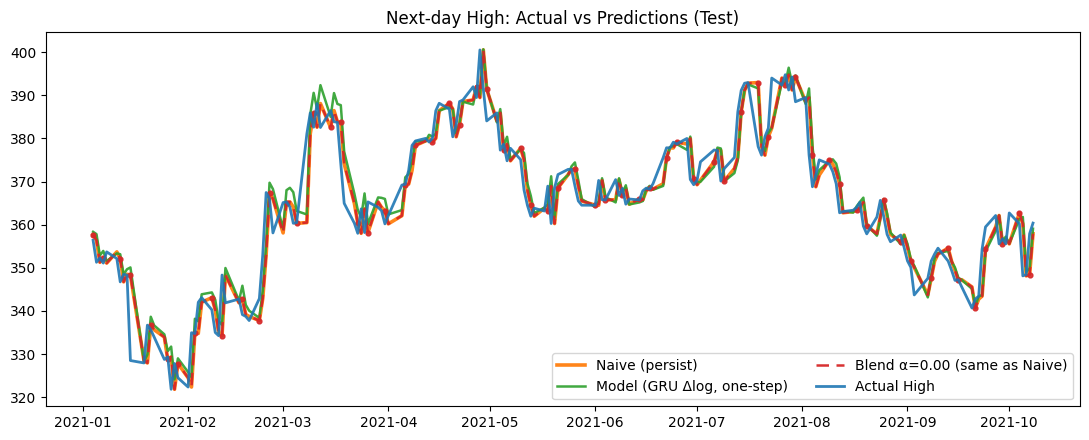

In [ ]:
# ============================================================
# AIB 552 DEEP LEARNING & NEURAL NETWORK [GROUP BASED ASSIGNMENT]
# BUSINESS-COMMENTED REFERENCE IMPLEMENTATION
# Main Business Objective: Forecast next-day 'HIGH' price for a single stock.
# Business Context: Execution/risk teams want a point forecast (or band).
# Business Problem/Statement: For tomorrow’s High to set limit prices and plan liquidity.
# MODELS Comparision: We compare a GRU (deep learning) model against a trivial Naives machine learning model as a baseline,
# but very strong, business baseline: persistence (H_t ≈ H_{t-1}).
# We also “blend” the two models built on a validation period to avoid harm and risk, thus building a risk mitigation ensemble model.
# ============================================================

# ---------- 1) Imports (what each is used for in business terms) ----------
import numpy as np                    # efficient numerical arrays (for fast feature math)
import pandas as pd                   # time-series tabular handling (for OHLCV data)
from sklearn.preprocessing import StandardScaler  # scale features to stabilize training
from sklearn.metrics import mean_absolute_error, mean_squared_error  # business metrics
import tensorflow as tf               # deep learning framework for GRU/LSTM models
from tensorflow.keras import Sequential
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau  # training safeguards

# ---------- 2) Configuration (knobs that adjust cost/quality trade-offs) ----------
# path or URL to your OHLCV CSV (business data source)
CSV_PATH = "/content/drive/MyDrive/stock_history_downloaded.csv"
DATE_COL = "Date"                # the timestamp column to index the series

TRAIN_END_YEAR = 2020            # all dates <= 2020 are *training* (learn patterns)
VAL_FRAC = 0.20                  # last 20% of training period is *validation* (choose blend)
# Why separate validation? To choose a model/naive blend that *reduces* the risk of
# underperforming persistence when market regimes change.

N_STEPS = 60                     # lookback window (60 trading days ≈ 3 months of memory)
BATCH_SIZE = 32                  # mini-batch size (training throughput vs. noisy gradients)
EPOCHS = 60                      # upper bound on passes over training windows
SEED = 42                        # reproducibility (so stakeholders can reproduce results)

# For fair audits, results should be reproducible across reruns.
tf.keras.utils.set_random_seed(SEED)
np.random.seed(SEED)

# ---------- 3) Load the raw OHLCV data ----------
df = pd.read_csv(
    CSV_PATH,                     # can be local file or a raw GitHub URL
    parse_dates=[DATE_COL],       # parse the date column as datetime
    index_col=DATE_COL            # make date the DataFrame index (time-series ops)
)

# Some vendor CSVs include accounting fields not needed for next-day High.
for col in ["Dividends", "Stock Splits"]:
    if col in df.columns:
        df.drop(columns=col, inplace=True)

# Ensure chronological order; business reason: leakage/causality.
df.sort_index(inplace=True)
assert df.index.is_monotonic_increasing, "Dates must increase (no shuffling!)."

# Validate presence of core market fields; without them the business target is undefined.
required = {"Open", "High", "Low", "Close", "Volume"}
missing = required - set(df.columns)
if missing:
    raise ValueError(f"CSV missing columns required for forecasting: {missing}")

# ---------- 4) Feature engineering (cheap signals with business intuition) ----------
feat = pd.DataFrame(index=df.index)
# Copy raw OHLCV as base explanatory variables.
for c in ["Open", "High", "Low", "Close", "Volume"]:
    feat[c] = df[c].astype("float64")

# Previous close (for gaps/range features that traders care about).
prev_close = feat["Close"].shift(1)

# True Range proxy and ATR(14): measures intraday stress/liquidity risk.
tr = pd.concat([
    (feat["High"] - feat["Low"]).abs(),         # range of the day
    (feat["High"] - prev_close).abs(),          # overnight shock to the upside
    (feat["Low"]  - prev_close).abs()           # overnight shock to the downside
], axis=1).max(axis=1)
feat["atr14"] = tr.rolling(14).mean()           # smooth shock measure ~ 3 weeks

# Normalized intraday range: how “stretched” the day is relative to price level.
feat["range_norm"] = (feat["High"] - feat["Low"]) / feat["Close"].replace(0, np.nan)

# Opening gap relative to previous close: important for next-day extremes.
feat["gap_open"]   = (feat["Open"] - prev_close) / prev_close

# Short/medium trend anchors: execution teams often reference these anchors.
feat["ma5"]  = feat["Close"].rolling(5).mean()     # ~1 week
feat["ma20"] = feat["Close"].rolling(20).mean()    # ~1 month
feat["ma_ratio"] = feat["ma5"] / feat["ma20"]      # trend state indicator

# Log returns for High & Close; returns are closer to stationary → easier to learn.
logH = np.log(feat["High"])
retH = logH.diff()                     # Δlog(High): our modeling target family
feat["ret_h"] = retH
feat["ret_c"] = np.log(feat["Close"]).diff()

# Realized volatility of High returns over 10 days: affects next-day range.
feat["rvol10"] = retH.rolling(10).std()

# Calendar effects (weak but free features; e.g., Monday effect).
feat["dow_sin"] = np.sin(2*np.pi*feat.index.dayofweek/7)
feat["dow_cos"] = np.cos(2*np.pi*feat.index.dayofweek/7)

# ---------- 5) Target construction ----------
# We model *next-day* Δlog(High). This targets the day-ahead change in High,
# which we later map back to a level using the ACTUAL last price (one-step mapping).
y = retH.shift(-1)   # shift by -1 so today's features predict tomorrow’s High return

# Merge features + target; drop rows with NaNs from diffs/rolls.
data = pd.concat([feat, y.rename("y")], axis=1).dropna()

# ---------- 6) Time split: training, validation (inside train), and test ----------
# Business rationale:
# - Train (≤2020): learn general patterns.
# - Validation (last 20% of train): choose the blend weight α to *avoid harm*.
# - Test (≥2021): honest out-of-sample performance for decision making.
all_train = data[data.index.year <= TRAIN_END_YEAR].copy()
test      = data[data.index.year >= TRAIN_END_YEAR + 1].copy()

n_train = len(all_train)
n_val   = int(max(50, VAL_FRAC * n_train))    # ensure at least ~50 days of validation
train_core = all_train.iloc[:n_train - n_val] # used to fit scalers and model
val_hold   = all_train.iloc[n_train - n_val:] # used ONLY to pick α (no fitting)

X_cols = [c for c in data.columns if c != "y"]  # explanatory columns

# ---------- 7) Scaling (fit on train_core ONLY to avoid leakage) ----------
x_scaler = StandardScaler().fit(train_core[X_cols].values)  # stabilizes magnitudes across features
y_scaler = StandardScaler().fit(train_core[["y"]].values)   # stabilizes target variance

def scale_block(block):
    """Apply train_core scalers to a block of rows; keeps validation/test clean."""
    X = x_scaler.transform(block[X_cols].values)
    y = y_scaler.transform(block[["y"]].values)
    return X, y

# Apply scaling to each segment.
X_train_core, y_train_core = scale_block(train_core)
X_val_hold,  y_val_hold    = scale_block(val_hold)
X_test,      y_test        = scale_block(test)

# ---------- 8) Windowing (create 3D tensors for the GRU) ----------
def make_windows(X2d, y2d, n_steps):
    """
    Turn a 2D array [T, F] into sequences [N, n_steps, F] with aligned labels [N, 1].
    Business view: each sample is a rolling 60-day “panel” that predicts tomorrow.
    """
    Xw, yw = [], []
    for i in range(n_steps, len(X2d)):
        Xw.append(X2d[i-n_steps:i, :])  # the past n_steps days
        yw.append(y2d[i, 0])            # the next-day target aligned to that window
    return np.asarray(Xw, np.float32), np.asarray(yw, np.float32).reshape(-1,1)

# Training windows come only from train_core → model learns from patterns prior to validation.
Xtr, ytr = make_windows(X_train_core, y_train_core, N_STEPS)

# Validation windows need *context* from the end of train_core for the first val sample.
X_val_ctx = np.vstack([X_train_core[-N_STEPS:], X_val_hold])
y_val_ctx = np.vstack([y_train_core[-N_STEPS:], y_val_hold])
Xv, yv = make_windows(X_val_ctx, y_val_ctx, N_STEPS)

# Test windows use context from ALL training days → predictions cover ALL test dates.
X_train_all, y_train_all = scale_block(all_train)
X_test_ctx = np.vstack([X_train_all[-N_STEPS:], X_test])
y_test_ctx = np.vstack([y_train_all[-N_STEPS:], y_test])
Xte, yte = make_windows(X_test_ctx, y_test_ctx, N_STEPS)

n_features = Xtr.shape[-1]  # number of explanatory features per day

# ---------- 9) GRU model (compact; robust loss) ----------
def make_model(n_steps, n_features):
    """
    GRU with Huber loss: small, fast, less prone to overfit, and robust to spikes (earnings days).
    Business goal: learn a *residual* signal over simple heuristics without overfitting noise.
    """
    model = Sequential([
        tf.keras.Input(shape=(n_steps, n_features)),  # accept [batch, 60, F] windows
        GRU(64, dropout=0.15, recurrent_dropout=0.05),# single GRU layer (faster turning than deep stacks)
        Dense(1)                                      # linear head to predict Δlog(High)
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-3),     # stable default for sequence tasks
        loss=tf.keras.losses.Huber(delta=1.0),        # less sensitive than MSE to outliers
        metrics=[tf.keras.metrics.MeanAbsoluteError(name="mae")]
    )
    return model

model = make_model(N_STEPS, n_features)

# Training safeguards: early stop when validation loss stalls; reduce LR on plateaus.
es  = EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True)
rlr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=4, min_lr=1e-5, verbose=1)

# Fit on *training* only; validate on the holdout to watch generalization.
hist = model.fit(
    Xtr, ytr,
    validation_data=(Xv, yv),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[es, rlr],
    verbose=1
)

# ---------- 10) One-step mapping helpers (business-safe reconstruction) ----------
def one_step_levels(ret_pred, last_level, true_levels):
    """
    Map predicted Δlog(High) to a *level* forecast using the ACTUAL last price.
    Rationale: avoids compounding tiny biases into a runaway drift, matching how
    the desk will really use a 1-day-ahead forecast.
    """
    out, prev = [], float(last_level)
    for r, actual in zip(ret_pred, true_levels):
        out.append(prev * np.exp(r))  # H_t_hat = H_{t-1} * exp(predicted return)
        prev = float(actual)          # next step anchors to ACTUAL H_t (not the prediction)
    return np.array(out).reshape(-1,1)

def naive_levels(last_level, true_levels):
    """
    Persistence baseline: tomorrow’s High equals today’s High.
    This is the strong business baseline we must beat to be useful.
    """
    out, prev = [], float(last_level)
    for actual in true_levels:
        out.append(prev)
        prev = float(actual)
    return np.array(out).reshape(-1,1)

# ---------- 11) Choose blend weight α on *validation* (risk-aware) ----------
# Predict standardized returns on validation windows, then invert scaling.
yhat_val_std = model.predict(Xv, verbose=0)
yhat_val_ret = y_scaler.inverse_transform(yhat_val_std).ravel()

# Seed for the first validation prediction is the last High from train_core.
last_train_core_high = float(feat.loc[train_core.index[-1], "High"])
H_true_val = feat.loc[val_hold.index, "High"].values

# Build the model and naive *level* forecasts on validation.
H_hat_val   = one_step_levels(yhat_val_ret, last_train_core_high, H_true_val)
H_naive_val = naive_levels(last_train_core_high, H_true_val)

# Pick α∈[0,1] that minimizes MAE on validation (business: minimizes expected slippage).
alphas = np.linspace(0, 1, 21)  # coarse grid is enough; keeps selection stable
mae_by_alpha = []
for a in alphas:
    H_blend = a*H_hat_val + (1-a)*H_naive_val  # convex combination of model and naive
    mae_by_alpha.append(mean_absolute_error(H_true_val, H_blend))
best_alpha = float(alphas[int(np.argmin(mae_by_alpha))])
print(f"Chosen blend alpha (on validation): {best_alpha:.2f}")

# ---------- 12) Make TEST forecasts ----------
# Predict returns for test windows and invert scaling to raw Δlog(High).
yhat_test_std = model.predict(Xte, verbose=0)
yhat_test_ret = y_scaler.inverse_transform(yhat_test_std).ravel()

# Seed for test is the final High from ALL training days.
last_all_train_high = float(feat.loc[all_train.index[-1], "High"])
H_true_test = feat.loc[test.index, "High"].values

# Level forecasts for model, naive, and the chosen blend.
H_hat_test   = one_step_levels(yhat_test_ret, last_all_train_high, H_true_test)
H_naive_test = naive_levels(last_all_train_high, H_true_test)
H_blend_test = best_alpha*H_hat_test + (1-best_alpha)*H_naive_test  # risk-managed forecast

# ---------- 13) Metrics (business-interpretable) ----------
def series_metrics(y_true, y_pred, y_naive):
    """
    Compute:
      - RMSE/MAE: absolute accuracy in price units (slippage proxy)
      - MAPE: percent error (less useful if baseline is already strong)
      - Skill (RMSE): improvement vs naive (>0 means better than naive)
      - MASE: MAE normalized by naive MAE (<1 means better than naive)
      - Directional accuracy: pct of correctly predicted up/down days (>0.5 desired)
    """
    y_true, y_pred, y_naive = y_true.ravel(), y_pred.ravel(), y_naive.ravel()
    rmse  = float(np.sqrt(mean_squared_error(y_true, y_pred)))
    mae   = float(mean_absolute_error(y_true, y_pred))
    mape  = float(np.mean(np.abs((y_pred - y_true) / np.clip(y_true, 1e-12, None))) * 100)

    rmse_n = float(np.sqrt(mean_squared_error(y_true, y_naive)))
    mae_n  = float(mean_absolute_error(y_true, y_naive))

    skill = 1 - rmse / rmse_n
    mase  = mae / mae_n

    # Directional accuracy on *levels* (drop first diff where sign undefined)
    da = float(np.mean(((y_pred[1:] - y_pred[:-1]) * (y_true[1:] - y_true[:-1])) > 0))
    return rmse, mae, mape, rmse_n, mae_n, skill, mase, da

# Evaluate raw model vs naive …
rmse_m, mae_m, mape_m, rmse_n, mae_n, skill_m, mase_m, da_m = series_metrics(
    H_true_test, H_hat_test, H_naive_test
)
# … and evaluate the blend (what you would actually ship).
rmse_b, mae_b, mape_b, _, _, skill_b, mase_b, da_b = series_metrics(
    H_true_test, H_blend_test, H_naive_test
)

# Report in language that stakeholders understand (units & baseline-relative).
print("\n=== Test metrics (MODEL) ===")
print(f"RMSE: {rmse_m:.3f}  MAE: {mae_m:.3f}  MAPE: {mape_m:.2f}%")
print(f"Naive RMSE: {rmse_n:.3f}  Naive MAE: {mae_n:.3f}")
print(f"Skill vs naive (RMSE): {skill_m:.3f}   MASE: {mase_m:.3f}   Directional acc: {da_m:.3f}")

print("\n=== Test metrics (BLEND) ===")
print(f"RMSE: {rmse_b:.3f}  MAE: {mae_b:.3f}  MAPE: {mape_b:.2f}%")
print(f"Skill vs naive (RMSE): {skill_b:.3f}   MASE: {mase_b:.3f}   Directional acc: {da_b:.3f}")

# ---------- 14) Plotting (make all lines visible; avoid overdraw) ----------
try:
    import matplotlib.pyplot as plt
    import matplotlib.patheffects as pe  # white stroke to keep lines readable on overlap

    # Detect if blend == naive (e.g., α=0) to style lines so both are visible.
    same_blend_naive = np.allclose(H_blend_test, H_naive_test, rtol=1e-10, atol=1e-10)

    plt.figure(figsize=(11,4.5))

    # 1) Naive forecast: orange, thicker, with white under-stroke (baseline the desk knows)
    plt.plot(
        test.index, H_naive_test.ravel(),
        color='tab:orange', lw=2.6, alpha=0.95, label="Naive (persist)",
        path_effects=[pe.withStroke(linewidth=4, foreground='white')], zorder=2
    )

    # 2) Model: green (what the DL system adds over business heuristics)
    plt.plot(
        test.index, H_hat_test.ravel(),
        color='tab:green', lw=1.8, alpha=0.9,
        label="Model (GRU Δlog, one-step)", zorder=3
    )

    # 3) Blend: red dashed; if identical to naive, annotate to prevent confusion
    blend_label = f"Blend α={best_alpha:.2f}" + (" (same as Naive)" if same_blend_naive else "")
    plt.plot(
        test.index, H_blend_test.ravel(),
        color='tab:red', lw=1.8, alpha=0.95, linestyle='--', dashes=(5,3),
        label=blend_label, zorder=4
    )
    if same_blend_naive:
        # Add sparse markers so stakeholders can still “see” the red series on top of orange
        step = max(1, len(test)//50)
        plt.scatter(test.index[::step], H_blend_test.ravel()[::step],
                    color='tab:red', s=12, alpha=0.9, zorder=5)

    # 4) Actual series: blue, drawn last so it is clearly visible for error inspection
    plt.plot(
        test.index, H_true_test,
        color='tab:blue', lw=2.0, alpha=0.9, label="Actual High", zorder=6
    )

    plt.title("Next-day High: Actual vs Predictions (Test)")
    plt.legend(ncol=2, frameon=True)
    plt.tight_layout()
    plt.show()
except Exception as e:
    # Plotting may fail in headless environments; printing a message avoids crashing pipelines.
    print("Plot skipped:", e)

# Title & Objective: GRU Fine-Tuning (Random Search, accelerated) — minimize Validation MASE vs naïve; evaluate on Test


	•	0.1. Prerequisites from Main Namespace
	•	scale_block, train_core, val_hold, all_train, test, feat, y_scaler
	•	one_step_levels, naive_levels, series_metrics
	•	mean_absolute_error, mean_squared_error

	•	1. Core Imports
	•	NumPy, TensorFlow/Keras (GRU, Dense, LayerNormalization, Dropout, callbacks, regularizers), sklearn metrics, random
	•	1.1. Optional Speed Toggles
	•	XLA JIT (USE_XLA), mixed precision (USE_MIXED_PRECISION), thread caps (NUM_THREADS)

	•	2. Fast Windowing & Caching Utilities
	•	_WINDOW_CACHE, _PRECOMP_VAL stores
	•	_vectorized_windowize(...) — vectorized rolling windows
	•	_init_precomp_validation_constants() — baseline metrics for validation
	•	prepare_windows_for(n_steps) — build/cache Train/Val/Test windows per lookback

	•	3. Configurable GRU Builder
	•	build_gru(...) — units, layers, dropout, recurrent dropout, L2, LR, clipnorm, Huber loss, optional LayerNorm, JIT

	•	4. tf.data Input Pipelines
	•	_make_ds(X, y, batch, shuffle) — batched, cached, prefetched datasets

	•	5. Validation Loop (Model Scoring)
	•	validate_params(params, n_steps) — train per-trial; compute Validation MASE (primary) and Skill vs naïve (tie-break) in level space

	•	6. Random Search Space & Sampler
	•	search_space for n_steps, units, layers, dropout, rdrop, l2, lr, clipnorm, huber_delta, batch_size, layernorm
	•	sample_params() — draw a trial configuration

	•	7. Random Search Execution
	•	Loop TRIALS = 20: train/score; log per-trial MASE & Skill; keep best (lowest MASE, Skill tie-break)

	•	8. Report Best Validation Configuration
	•	Print chosen hyperparameters and validation scores

	•	9. Retrain Best Model & Test Evaluation
	•	Rebuild windows for best n_steps; rebuild best GRU; callbacks (EarlyStopping, ReduceLROnPlateau)
	•	Fit on Train with Val monitoring; predict Test returns → inverse scale
	•	Reconstruct level forecasts via one_step_levels; build naïve via naive_levels
	•	Compute Test metrics via series_metrics (RMSE, MAE, MAPE, Skill, MASE, Directional Accuracy)

	•	10. Test Results Output
	•	Printed block: TEST (FINE-TUNED MODEL) with metrics vs naïve baseline
	•	Appendix / Notes (optional)
	•	Reproducibility seed (random.seed(123)); relies on scalers fit in main code; evaluates in level space to match business usage

In [ ]:
# =========================
# GRU FINE-TUNING (Random Search, accelerated)
# Objective: minimize VALIDATION MASE (model vs naive), then evaluate on TEST
# NOTE: This script expects the following from your main code namespace:
#   - scale_block, train_core, val_hold, all_train, test, feat, y_scaler
#   - one_step_levels, naive_levels, series_metrics
#   - from sklearn.metrics import mean_absolute_error, mean_squared_error
# =========================

# ---- Core imports
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import GRU, Dense, LayerNormalization, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import regularizers
from sklearn.metrics import mean_absolute_error, mean_squared_error
import random

# ==== Optional speed toggles (safe defaults) ====
USE_XLA = True                 # jit-compile small graphs; can speed up on many setups
USE_MIXED_PRECISION = False    # enable if on modern GPU (Ampere+); leave False on CPU
NUM_THREADS = None             # e.g. set to 4 to cap intra/inter op threads

if USE_XLA:
    try:
        tf.config.optimizer.set_jit(True)
    except Exception:
        pass

if USE_MIXED_PRECISION:
    try:
        from tensorflow.keras import mixed_precision
        mixed_precision.set_global_policy("mixed_float16")
    except Exception:
        pass

if NUM_THREADS is not None:
    tf.config.threading.set_intra_op_parallelism_threads(NUM_THREADS)
    tf.config.threading.set_inter_op_parallelism_threads(NUM_THREADS)

# =========================
# 1) Fast windowing + caching
# =========================
_WINDOW_CACHE = {}   # key: n_steps -> (Xtr, ytr, Xv, yv, Xte_w, yte_w, n_features)
_PRECOMP_VAL = {}    # constants for validation metrics (naive baseline etc.)

def _vectorized_windowize(X2d: np.ndarray, y2d: np.ndarray, n_steps: int):
    """
    Vectorized rolling windows:
      X2d [T, F] --> Xw [N, n_steps, F]
      y2d [T, 1] --> yw [N, 1] aligned to window end
    """
    T = X2d.shape[0]
    N = T - n_steps
    if N <= 0:
        return np.empty((0, n_steps, X2d.shape[1]), np.float32), np.empty((0, 1), np.float32)
    idx = np.arange(n_steps)[None, :] + np.arange(N)[:, None]  # [N, n_steps]
    Xw = X2d[idx]                         # [N, n_steps, F]
    yw = y2d[n_steps:, 0:1]               # [N, 1]
    return Xw.astype(np.float32), yw.astype(np.float32)

def _init_precomp_validation_constants():
    """Compute constants used in every trial once."""
    if _PRECOMP_VAL:
        return
    last_train_core_high = float(feat.loc[train_core.index[-1], "High"])
    H_true_val = feat.loc[val_hold.index, "High"].values
    H_naive_val = naive_levels(last_train_core_high, H_true_val)
    mae_naive = mean_absolute_error(H_true_val, H_naive_val)
    rmse_naive = float(np.sqrt(mean_squared_error(H_true_val, H_naive_val)))
    _PRECOMP_VAL.update(dict(
        last_train_core_high=last_train_core_high,
        H_true_val=H_true_val,
        H_naive_val=H_naive_val,
        mae_naive=mae_naive,
        rmse_naive=rmse_naive,
    ))

def prepare_windows_for(n_steps: int):
    """
    Build/cached train/val/test windows for a given lookback length.
    Uses scalers fit on train_core (from main code). Results are cached per n_steps.
    """
    if n_steps in _WINDOW_CACHE:
        return _WINDOW_CACHE[n_steps]

    # Standardized blocks (scalers already trained in main code)
    X_trc, y_trc = scale_block(train_core)
    X_val, y_val = scale_block(val_hold)
    X_all, y_all = scale_block(all_train)
    X_te,  y_te  = scale_block(test)

    # Training
    Xtr, ytr = _vectorized_windowize(X_trc, y_trc, n_steps)

    # Validation (bridge with trailing n_steps from train_core)
    Xv_ctx = np.vstack([X_trc[-n_steps:], X_val])
    yv_ctx = np.vstack([y_trc[-n_steps:], y_val])
    Xv, yv = _vectorized_windowize(Xv_ctx, yv_ctx, n_steps)

    # Test (bridge with trailing n_steps from ALL training)
    Xte_ctx = np.vstack([X_all[-n_steps:], X_te])
    yte_ctx = np.vstack([y_all[-n_steps:], y_te])
    Xte_w, yte_w = _vectorized_windowize(Xte_ctx, yte_ctx, n_steps)

    pack = (Xtr, ytr, Xv, yv, Xte_w, yte_w, Xtr.shape[-1])
    _WINDOW_CACHE[n_steps] = pack
    return pack

# =========================
# 2) Compact GRU builder (unchanged objective)
# =========================
def build_gru(n_steps, n_features, units=96, layers=2, dropout=0.20, rdrop=0.05,
              l2=1e-5, lr=5e-4, huber_delta=1.0, clipnorm=1.0, layernorm=True, jit_compile=False):
    model = Sequential()
    model.add(tf.keras.Input(shape=(n_steps, n_features)))
    for li in range(layers):
        return_sequences = (li < layers-1)
        model.add(GRU(
            units,
            return_sequences=return_sequences,
            dropout=dropout,
            recurrent_dropout=rdrop,
            kernel_regularizer=regularizers.l2(l2),
        ))
        if layernorm and not return_sequences:
            model.add(LayerNormalization())
        if return_sequences:
            model.add(Dropout(dropout))
    model.add(Dense(1))
    opt = tf.keras.optimizers.Adam(learning_rate=lr, clipnorm=clipnorm)
    model.compile(
        optimizer=opt,
        loss=tf.keras.losses.Huber(delta=huber_delta),
        metrics=[tf.keras.metrics.MeanAbsoluteError(name="mae")],
        jit_compile=jit_compile
    )
    return model

# =========================
# 3) tf.data helpers (faster I/O)
# =========================
def _make_ds(X, y, batch, shuffle=True):
    ds = tf.data.Dataset.from_tensor_slices((X, y))
    if shuffle:
        ds = ds.shuffle(min(len(X), 10000), seed=123, reshuffle_each_iteration=True)
    ds = ds.batch(batch).cache().prefetch(tf.data.AUTOTUNE)
    return ds

# =========================
# 4) Validation loop (MASE primary, skill tie-break)
# =========================
def validate_params(params, n_steps):
    """
    Train a model for the sampled hyperparameters; score VALIDATION in level space.
    Returns: (model, mase, skill)
    """
    # Free previous graphs to reduce memory growth and slowdown
    tf.keras.backend.clear_session()

    # Windows
    Xtr, ytr, Xv, yv, _, _, nf = prepare_windows_for(n_steps)

    # Build
    gru_params = {k: v for k, v in params.items() if k not in ("batch_size",)}
    m = build_gru(n_steps, nf, **gru_params, jit_compile=USE_XLA)

    # Callbacks
    es  = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
    rlr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-5, verbose=0)

    # Datasets (faster than feeding numpy arrays)
    bs = int(params.get("batch_size", 32))
    ds_tr  = _make_ds(Xtr, ytr, bs, shuffle=True)
    ds_val = _make_ds(Xv,  yv,  bs, shuffle=False)

    # Train
    m.fit(ds_tr, validation_data=ds_val, epochs=80, callbacks=[es, rlr], verbose=0)

    # ---- VALIDATION metrics in level space (same objective as before)
    _init_precomp_validation_constants()
    yhat_v_std = m.predict(Xv, batch_size=bs, verbose=0)
    yhat_v_ret = y_scaler.inverse_transform(yhat_v_std).ravel()

    last_train_core_high = _PRECOMP_VAL["last_train_core_high"]
    H_true_val = _PRECOMP_VAL["H_true_val"]
    H_hat_val  = one_step_levels(yhat_v_ret, last_train_core_high, H_true_val)
    H_naive_val= _PRECOMP_VAL["H_naive_val"]

    mae_model = mean_absolute_error(H_true_val, H_hat_val)
    mase = mae_model / (_PRECOMP_VAL["mae_naive"] + 1e-12)

    rmse_model = float(np.sqrt(mean_squared_error(H_true_val, H_hat_val)))
    skill = 1 - rmse_model / (_PRECOMP_VAL["rmse_naive"] + 1e-12)

    return m, mase, skill

# =========================
# 5) Random search space (unchanged semantics)
# =========================
random.seed(123)

search_space = {
    "n_steps":      [40, 60, 90, 120],
    "units":        [64, 96, 128],
    "layers":       [1, 2],
    "dropout":      [0.10, 0.20, 0.30],
    "rdrop":        [0.00, 0.05, 0.10],
    "l2":           [0.0, 1e-5, 1e-4],
    "lr":           [1e-3, 5e-4, 3e-4, 1e-4],
    "clipnorm":     [0.5, 1.0],
    "huber_delta":  [0.5, 1.0, 1.5],
    "batch_size":   [16, 32, 64],
    "layernorm":    [True, False],
}

def sample_params():
    return {
        "units":       random.choice(search_space["units"]),
        "layers":      random.choice(search_space["layers"]),
        "dropout":     random.choice(search_space["dropout"]),
        "rdrop":       random.choice(search_space["rdrop"]),
        "l2":          random.choice(search_space["l2"]),
        "lr":          random.choice(search_space["lr"]),
        "clipnorm":    random.choice(search_space["clipnorm"]),
        "huber_delta": random.choice(search_space["huber_delta"]),
        "batch_size":  random.choice(search_space["batch_size"]),
        "layernorm":   random.choice(search_space["layernorm"]),
    }

# =========================
# 6) Random search (same budget; faster per trial)
# =========================
best = None
TRIALS = 20

for t in range(TRIALS):
    n_steps = random.choice(search_space["n_steps"])
    params  = sample_params()

    _, mase, skill = validate_params(params, n_steps)

    record = {
        "trial": t + 1, "n_steps": n_steps, **params,
        "val_mase": float(mase), "val_skill": float(skill)
    }

    if (best is None) or (record["val_mase"] < best["val_mase"] or
                          (np.isclose(record["val_mase"], best["val_mase"]) and record["val_skill"] > best["val_skill"])):
        best = record

    print(f"Trial {t+1:02d}: MASE={record['val_mase']:.3f}, Skill={record['val_skill']:.3f}, "
          f"cfg={{'n_steps':{record['n_steps']}, 'units':{record['units']}, 'layers':{record['layers']}, "
          f"'dropout':{record['dropout']}, 'rdrop':{record['rdrop']}, 'lr':{record['lr']}, 'l2':{record['l2']}}}")

print("\nBest on VALIDATION:", best)

# =========================
# 7) Retrain best on train/val and evaluate on TEST
# =========================
# Regenerate/cached windows for the best lookback
Xtr, ytr, Xv, yv, Xte_w, yte_w, nf = prepare_windows_for(best["n_steps"])

best_params = {k: best[k] for k in ["units","layers","dropout","rdrop","l2",
                                    "lr","clipnorm","huber_delta","layernorm"]}

tf.keras.backend.clear_session()
model_best = build_gru(best["n_steps"], nf, **best_params, jit_compile=USE_XLA)

es  = EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True)
rlr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=4, min_lr=1e-5, verbose=1)

bs = int(best["batch_size"])
ds_tr  = _make_ds(Xtr, ytr, bs, shuffle=True)
ds_val = _make_ds(Xv,  yv,  bs, shuffle=False)

model_best.fit(ds_tr, validation_data=ds_val,
               epochs=120, callbacks=[es, rlr], verbose=1)

# TEST predictions (returns -> levels)
yhat_te_std = model_best.predict(Xte_w, batch_size=bs, verbose=0)
yhat_te_ret = y_scaler.inverse_transform(yhat_te_std).ravel()

last_all_train_high = float(feat.loc[all_train.index[-1], "High"])
H_true_test = feat.loc[test.index, "High"].values
H_hat_test  = one_step_levels(yhat_te_ret, last_all_train_high, H_true_test)
H_naive_test= naive_levels(last_all_train_high, H_true_test)

rmse_m, mae_m, mape_m, rmse_n, mae_n, skill_m, mase_m, da_m = series_metrics(H_true_test, H_hat_test, H_naive_test)
print("\n=== TEST (FINE-TUNED MODEL) ===")
print(f"RMSE: {rmse_m:.3f}  MAE: {mae_m:.3f}  MAPE: {mape_m:.2f}%")
print(f"Naive RMSE: {rmse_n:.3f}  Naive MAE: {mae_n:.3f}")
print(f"Skill vs naive (RMSE): {skill_m:.3f}   MASE: {mase_m:.3f}   Directional acc: {da_m:.3f}")

Trial 01: MASE=1.017, Skill=-0.027, cfg={'n_steps':40, 'units':96, 'layers':1, 'dropout':0.2, 'rdrop':0.05, 'lr':0.001, 'l2':0.0}
Trial 02: MASE=0.992, Skill=0.001, cfg={'n_steps':60, 'units':96, 'layers':2, 'dropout':0.3, 'rdrop':0.0, 'lr':0.001, 'l2':0.0}
Trial 03: MASE=1.021, Skill=-0.037, cfg={'n_steps':40, 'units':128, 'layers':1, 'dropout':0.1, 'rdrop':0.0, 'lr':0.0001, 'l2':1e-05}
Trial 04: MASE=0.992, Skill=-0.005, cfg={'n_steps':120, 'units':64, 'layers':2, 'dropout':0.1, 'rdrop':0.05, 'lr':0.0001, 'l2':0.0001}
Trial 05: MASE=0.991, Skill=-0.001, cfg={'n_steps':40, 'units':96, 'layers':2, 'dropout':0.1, 'rdrop':0.05, 'lr':0.0001, 'l2':1e-05}
Trial 06: MASE=0.991, Skill=-0.003, cfg={'n_steps':90, 'units':64, 'layers':2, 'dropout':0.1, 'rdrop':0.05, 'lr':0.001, 'l2':0.0001}
Trial 07: MASE=1.032, Skill=-0.041, cfg={'n_steps':120, 'units':64, 'layers':1, 'dropout':0.1, 'rdrop':0.05, 'lr':0.001, 'l2':0.0}
Trial 08: MASE=1.021, Skill=-0.024, cfg={'n_steps':40, 'units':128, 'layers':

# Diebold–Mariano (DM)

In [ ]:
# Statistical test.

# To perform a significance check, use a Diebold–Mariano (DM) test on the test-set loss differential (MAE and MSE).
# If the DM statistic is > 0 and significant for d_t = |e_GRU| − |e_naive|, naïve is significantly better in MAE (and similarly for squared errors).

In [ ]:
import numpy as np

# Assume you already have these arrays from your pipeline:
# H_true_test, H_hat_test, H_naive_test  (all shape [T, 1] or [T,])

def dm_test(loss_diff, h=1):
    """
    Simple DM test with Newey-West variance (lag = h-1 for 1-step ahead -> 0).
    Returns (stat, p_two_sided). For multi-step horizons, set h accordingly.
    """
    d = loss_diff - np.mean(loss_diff)
    T = len(d)
    # Newey-West variance with Bartlett weights up to lag L=h-1 (0 for 1-step)
    L = max(0, h-1)
    gamma0 = np.mean(d*d)
    var = gamma0
    for l in range(1, L+1):
        w = 1 - l/(L+1)
        cov = np.mean(d[l:] * d[:-l])
        var += 2*w*cov
    stat = np.mean(loss_diff) / np.sqrt(var / T + 1e-12)
    # Two-sided p-value under N(0,1)
    from math import erf, sqrt
    def norm_cdf(x): return 0.5*(1+erf(x/sqrt(2)))
    p = 2*(1 - norm_cdf(abs(stat)))
    return stat, p

# Errors
e_gru   = (H_true_test.ravel()  - H_hat_test.ravel())
e_naive = (H_true_test.ravel()  - H_naive_test.ravel())

# MAE differential (positive mean => GRU worse; negative => GRU better)
d_mae = np.abs(e_gru) - np.abs(e_naive)
stat_mae, p_mae = dm_test(d_mae, h=1)
print(f"DM MAE: stat={stat_mae:.3f}, p={p_mae:.3f}  (mean diff={np.mean(d_mae):.4f})")

# MSE differential (positive mean => GRU worse; negative => GRU better)
d_mse = e_gru**2 - e_naive**2
stat_mse, p_mse = dm_test(d_mse, h=1)
print(f"DM MSE: stat={stat_mse:.3f}, p={p_mse:.3f}  (mean diff={np.mean(d_mse):.4f})")

DM MAE: stat=1.651, p=0.099  (mean diff=0.1082)
DM MSE: stat=1.448, p=0.148  (mean diff=1.0842)


# Areas of Targeted Improvement: New Proposed GRU Model Methodology:

# Title & Objective: Upper-band forecasting for next-day High using Close→High log-ratio with pinball loss (τ = 0.90); build a risk-aware blend vs naïve.

	•	0.1. Business Setup
	•	Goal: set conservative limit prices and plan liquidity.
	•	Strategy: GRU model + naïve persistence → validated blend to avoid harm.

	•	1. Imports
	•	OS, NumPy, Pandas, scikit-learn (scalers/metrics), TensorFlow/Keras (GRU, Dense, callbacks).

	•	2. Configuration & Reproducibility
	•	Paths (CSV_PATH, optional SPY/VIX/EARN), splits (TRAIN_END_YEAR, VAL_SLICES), training knobs (N_STEPS, BATCH_SIZE, EPOCHS, SEED), quantile τ.

	•	3. Data Load & Sanity Checks
	•	Read OHLCV, drop vendor extras, sort chronologically, assert required columns.

	•	4. Optional Exogenous Merges
	•	Helper: maybe_merge_csv(...) (date join, resample daily, ffill).
	•	Merge SPY (Close/Adj Close), VIX (Close), earnings flags (fallback 0 if missing).

	•	5. Feature Engineering
	•	Raw OHLCV; prev_close; ATR14, normalized range, open gap.
	•	Trends: ma5, ma20, ma_ratio.
	•	Returns/vol: ret_h, ret_c, rvol10.
	•	Calendar: dow_sin, dow_cos.
	•	Exogenous derivatives (if present): spy_ret, spy_ma5, vix_lvl, vix_chg, earn_tom.

	•	6. Target Construction (Upper Band)
	•	Define ratio = log(High_t / Close_{t−1}); target y = ratio.shift(-1).
	•	Combine features + target; drop NaNs.

	•	7. Time Splits
	•	all_train (≤ TRAIN_END_YEAR), test (≥ TRAIN_END_YEAR+1).
	•	Within-train recent validation block (val_hold) for blend selection.

	•	8. Scaling
	•	StandardScaler fit on train_core; helper scale_block(...) for Train/Val/Test.

	•	9. Windowing
	•	make_windows(...) → 3D tensors for GRU.
	•	Build Xtr/ytr, Xv/yv (with context bridge), Xte/yte (with full training context).
	•	Infer n_features.

	•	10. Loss Function
	•	pinball_loss(tau=TAU) — quantile (pinball) loss for the 90th percentile.

	•	11. GRU Model
	•	make_model(n_steps, n_features) — 2-layer GRU (96→64), dropout + recurrent_dropout, Dense(1) head; optimizer Adam(3e-4); loss = pinball(τ).

	•	12. Training Safeguards & Fit
	•	Callbacks: EarlyStopping, ReduceLROnPlateau.
	•	Train on Train windows; validate on recent Val block.

	•	13. Mapping Helpers (Ratio → Level)
	•	ratio_to_level(...) maps predicted log-ratio to High level using prev Close.
	•	naive_high(...) persistence baseline (High_t ≈ High_{t−1}).

	•	14. Rolling-Origin Blend Weight (α)
	•	Predict on Val, inverse-scale, map to levels.
	•	Slice recent validation into VAL_SLICES; grid-search α∈[0,1]; median α across slices.

	•	15. Test-Set Forecasts
	•	Predict on Test windows; inverse-scale; map to levels.
	•	Produce GRU, Naïve, and Blend (α) forecasts.

	•	16. Metrics & Reporting
	•	series_metrics(...): RMSE, MAE, MAPE, Skill vs naïve, MASE, directional accuracy.
	•	Print blocks for GRU and RISK-AWARE BLEND.

	•	17. Visualization
	•	Plot Actual vs Naïve (orange), GRU (green), Blend (red dashed); annotate if Blend≈Naïve.

	•	Appendix / Notes
	•	Code runs even if exogenous CSVs are missing (features default safe).
	•	Recent-slice validation targets non-stationarity; α guards against regression to worse-than-naïve.

Epoch 1/60
90/90 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - loss: 0.2588 - mae: 0.7319 - val_loss: 0.1912 - val_mae: 1.2584 - learning_rate: 3.0000e-04
Epoch 2/60
90/90 ━━━━━━━━━━━━━━━━━━━━ 13s 147ms/step - loss: 0.1777 - mae: 1.1009 - val_loss: 0.1908 - val_mae: 1.0282 - learning_rate: 3.0000e-04
Epoch 3/60
90/90 ━━━━━━━━━━━━━━━━━━━━ 21s 148ms/step - loss: 0.1757 - mae: 1.0996 - val_loss: 0.1854 - val_mae: 0.9431 - learning_rate: 3.0000e-04
Epoch 4/60
90/90 ━━━━━━━━━━━━━━━━━━━━ 20s 144ms/step - loss: 0.1747 - mae: 1.0946 - val_loss: 0.1902 - val_mae: 0.9999 - learning_rate: 3.0000e-04
Epoch 5/60
90/90 ━━━━━━━━━━━━━━━━━━━━ 20s 141ms/step - loss: 0.1748 - mae: 1.1262 - val_loss: 0.2056 - val_mae: 0.8049 - learning_rate: 3.0000e-04
Epoch 6/60
90/90 ━━━━━━━━━━━━━━━━━━━━ 20s 136ms/step - loss: 0.1759 - mae: 1.0952 - val_loss: 0.1892 - val_mae: 0.8408 - learning_rate: 3.0000e-04
Epoch 7/60
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 0.1728 - mae: 1.0960
Epoch 7: ReduceLROnPlateau reducing l

Chosen α (median over 4 recent slices): 0.23

=== Test metrics (GRU upper-quantile model) ===
RMSE: 6.216  MAE: 5.514  MAPE: 1.52%
Naive RMSE: 5.275  Naive MAE: 3.836
Skill vs naive (RMSE): -0.178   MASE: 1.437   Directional acc: 0.632

=== Test metrics (RISK-AWARE BLEND) ===
RMSE: 4.980  MAE: 3.704  MAPE: 1.02%
Skill vs naive (RMSE): 0.056   MASE: 0.966   Directional acc: 0.539


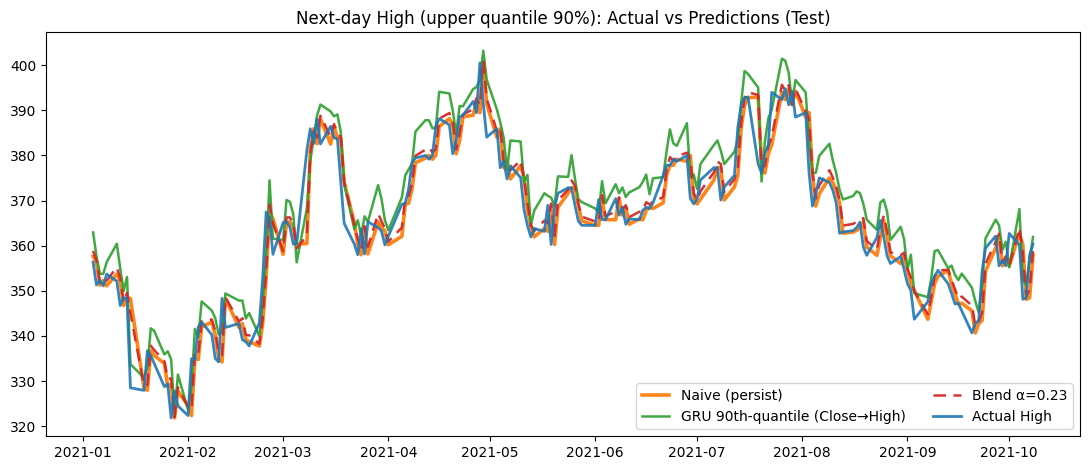

In [ ]:
# ============================================================
# AIB 552 DEEP LEARNING & NEURAL NETWORK [GROUP BASED ASSIGNMENT]
# Business objective: forecast an *upper band* for tomorrow’s High.
# Modeling: predict next-day Close→High ratio (log), train with pinball loss (τ=0.90),
# optionally enrich features with exogenous series (index, VIX, earnings), and choose a blend.
# weight α via rolling-origin validation on *recent* slices of the training period.
# ============================================================

# ---------- 1) Imports ----------
import os                                   # file existence checks for optional merges
import numpy as np                          # fast numeric arrays
import pandas as pd                         # time-series / table ops
from sklearn.preprocessing import StandardScaler  # scaling for features/target
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf                     # deep learning framework
from tensorflow.keras import Sequential
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# ---------- 2) Configuration ----------
# Core OHLCV path
CSV_PATH = "/content/drive/MyDrive/stock_history_downloaded.csv"
DATE_COL = "Date"

# OPTIONAL exogenous sources (set to your own files; if not found, they’re skipped)
SPY_PATH   = "/content/drive/MyDrive/SPY_history.csv"          # must contain Date, Close (or Adj Close)
VIX_PATH   = "/content/drive/MyDrive/VIX_history.csv"          # must contain Date, Close
EARN_PATH  = "/content/drive/MyDrive/earnings_calendar.csv"    # must contain Date, ticker flag columns

# Splits & training parameters knobs
TRAIN_END_YEAR = 2020          # ≤ 2020 train; ≥ 2021 test
VAL_SLICES = 4                 # number of equal recent validation chunks inside all_train
N_STEPS = 60                   # GRU lookback (days)
BATCH_SIZE = 32
EPOCHS = 60
SEED = 42
TAU = 0.90                     # Quantile for pinball loss (upper band)

# Reproducibility using SEED
tf.keras.utils.set_random_seed(SEED)
np.random.seed(SEED)

# ---------- 3) Load base OHLCV --> Open High Low Close Volume ----------
df = pd.read_csv(
    CSV_PATH,
    parse_dates=[DATE_COL],    # parse dates
    index_col=DATE_COL         # use Date as index for time-series operation
)
# Drop vendor extras if present
for col in ["Dividends", "Stock Splits"]:
    if col in df.columns:
        df.drop(columns=col, inplace=True)

# Ensure chronological order (causality)
df.sort_index(inplace=True)
assert df.index.is_monotonic_increasing

# Sanity check for core columns (OHLCV)
required = {"Open", "High", "Low", "Close", "Volume"}
missing = required - set(df.columns)
if missing:
    raise ValueError(f"CSV missing columns required for forecasting: {missing}")

# ---------- 4) (Optional) Merge exogenous signals the naïve cannot use ----------
def maybe_merge_csv(left, path, date_col="Date", how="left", rename=None, select=None, prefix=None):
    """
    Try to merge an external CSV by date. If the file doesn't exist, return 'left' unchanged.
    - rename: dict of column renames after read
    - select: list of columns to keep before optional renaming
    - prefix: optional prefix to add after (select/rename)
    """
    if not os.path.exists(path):
        return left  # silently skip
    right = pd.read_csv(path, parse_dates=[date_col])
    if select:
        right = right[[date_col] + select].copy()
    if rename:
        right.rename(columns=rename, inplace=True)
    if prefix:
        # add prefix to payload columns (not the date)
        payload = [c for c in right.columns if c != date_col]
        right.rename(columns={c: f"{prefix}{c}" for c in payload}, inplace=True)
    right.set_index(date_col, inplace=True)
    # align frequency & forward-fill small missing gaps (index/VIX often have holidays)
    right = right.sort_index().asfreq("D")  # daily calendar
    right = right.ffill()
    return left.join(right, how=how)

# SPY (market index proxy)
df = maybe_merge_csv(
    df, SPY_PATH, rename=None,
    select=[c for c in ["Close", "Adj Close"] if c in pd.read_csv(SPY_PATH, nrows=1).columns] if os.path.exists(SPY_PATH) else None,
    prefix="spy_"
)

# VIX (implied vol level)
df = maybe_merge_csv(
    df, VIX_PATH, rename=None,
    select=["Close"] if os.path.exists(VIX_PATH) else None,
    prefix="vix_"
)

# Earnings/macro flags (binary 0/1 column like 'earnings_tomorrow')
if os.path.exists(EARN_PATH):
    earn = pd.read_csv(EARN_PATH, parse_dates=[DATE_COL]).set_index(DATE_COL).sort_index()
    # Expect either a ready-to-use boolean or create one; adapt to your schema
    if "earnings_tomorrow" not in earn.columns:
        # Fallback heuristic: if there's a 'event' text column marking earnings for the *next* trading day
        # Here we just create a dummy flag if any column exists; customize for your file
        earn["earnings_tomorrow"] = 0
    df = df.join(earn[["earnings_tomorrow"]], how="left").fillna({"earnings_tomorrow": 0})
else:
    df["earnings_tomorrow"] = 0  # neutral if file missing

# ---------- 5) Feature engineering ----------
feat = pd.DataFrame(index=df.index)

# Raw OHLCV (float64)
for c in ["Open", "High", "Low", "Close", "Volume"]:
    feat[c] = df[c].astype("float64")

# Price relatives & ranges
prev_close = feat["Close"].shift(1)
feat["atr14"]      = pd.concat([(feat["High"] - feat["Low"]).abs(),
                                (feat["High"] - prev_close).abs(),
                                (feat["Low"]  - prev_close).abs()], axis=1).max(axis=1).rolling(14).mean()
feat["range_norm"] = (feat["High"] - feat["Low"]) / feat["Close"].replace(0, np.nan)
feat["gap_open"]   = (feat["Open"] - prev_close) / prev_close

# Short/medium anchors
feat["ma5"]        = feat["Close"].rolling(5).mean()
feat["ma20"]       = feat["Close"].rolling(20).mean()
feat["ma_ratio"]   = feat["ma5"] / feat["ma20"]

# Log returns (High/Close); realized vol
logH               = np.log(feat["High"])
feat["ret_h"]      = logH.diff()
feat["ret_c"]      = np.log(feat["Close"]).diff()
feat["rvol10"]     = feat["ret_h"].rolling(10).std()

# Calendar effects
feat["dow_sin"]    = np.sin(2*np.pi*feat.index.dayofweek/7)
feat["dow_cos"]    = np.cos(2*np.pi*feat.index.dayofweek/7)

# --- Exogenous derived features (if present) ---
# SPY return and lagged levels (if merged)
if "spy_Close" in df.columns or "spy_Adj Close" in df.columns:
    spy_col = "spy_Adj Close" if "spy_Adj Close" in df.columns else "spy_Close"
    feat["spy_ret"] = np.log(df[spy_col]).diff()
    feat["spy_ma5"] = df[spy_col].rolling(5).mean() / df[spy_col].rolling(20).mean()

# VIX level and change (if merged)
if "vix_Close" in df.columns:
    feat["vix_lvl"] = df["vix_Close"]
    feat["vix_chg"] = df["vix_Close"].pct_change()

# Earnings flag (0/1) already joined above
feat["earn_tom"]   = df["earnings_tomorrow"].astype("float32")

# ---------- 6) Target: next-day *upper band* (Close→High ratio, log) ----------
# ratio_t = log( High_t / Close_{t-1} ) → use tomorrow’s ratio as the prediction target.
ratio = np.log(feat["High"] / prev_close)
y = ratio.shift(-1)                                # use today’s features to predict *tomorrow’s* ratio

# We will later map predictions back to levels via: High_hat_t = Close_{t-1} * exp(y_hat_t)

# Combine & drop NaNs from rolling/shift ops
data = pd.concat([feat, y.rename("y")], axis=1).dropna()

# ---------- 7) Train/Val/Test split ----------
all_train = data[data.index.year <= TRAIN_END_YEAR].copy()
test      = data[data.index.year >= TRAIN_END_YEAR + 1].copy()

# Within all_train, we’ll form a *recent* validation block and also carve it into several
# equally sized *rolling-origin* slices to choose α robustly.
n_train = len(all_train)
n_val   = max(60, int(0.20 * n_train))                    # at least ~3 months
train_core = all_train.iloc[:n_train - n_val]             # fit scalers + model here
val_hold   = all_train.iloc[n_train - n_val:]             # recent validation block

X_cols = [c for c in data.columns if c != "y"]

# ---------- 8) Scaling ----------
x_scaler = StandardScaler().fit(train_core[X_cols].values)
y_scaler = StandardScaler().fit(train_core[["y"]].values)

def scale_block(block):
    X = x_scaler.transform(block[X_cols].values)
    y = y_scaler.transform(block[["y"]].values)
    return X, y

X_train_core, y_train_core = scale_block(train_core)
X_val_hold,  y_val_hold    = scale_block(val_hold)
X_test,      y_test        = scale_block(test)

# ---------- 9) Windowing ----------
def make_windows(X2d, y2d, n_steps):
    Xw, yw = [], []
    for i in range(n_steps, len(X2d)):
        Xw.append(X2d[i-n_steps:i, :])
        yw.append(y2d[i, 0])
    return np.asarray(Xw, np.float32), np.asarray(yw, np.float32).reshape(-1,1)

# Train windows (from train_core)
Xtr, ytr = make_windows(X_train_core, y_train_core, N_STEPS)

# Validation windows need context from end of train_core
X_val_ctx = np.vstack([X_train_core[-N_STEPS:], X_val_hold])
y_val_ctx = np.vstack([y_train_core[-N_STEPS:], y_val_hold])
Xv, yv = make_windows(X_val_ctx, y_val_ctx, N_STEPS)

# Test windows need context from *all* training
X_train_all, y_train_all = scale_block(all_train)
X_test_ctx = np.vstack([X_train_all[-N_STEPS:], X_test])
y_test_ctx = np.vstack([y_train_all[-N_STEPS:], y_test])
Xte, yte = make_windows(X_test_ctx, y_test_ctx, N_STEPS)

n_features = Xtr.shape[-1]

# ---------- 10) Quantile (pinball) loss for τ=0.90 ----------
def pinball_loss(tau=TAU):
    # L_tau(y, yhat) = mean( max(tau*(y - yhat), (tau - 1)*(y - yhat)) )
    def loss(y_true, y_pred):
        e = y_true - y_pred
        return tf.reduce_mean(tf.maximum(tau*e, (tau-1.0)*e))
    return loss

# ---------- 11) GRU model ----------
def make_model(n_steps, n_features):
    model = Sequential([
        tf.keras.Input(shape=(n_steps, n_features)), # Input
        GRU(96, dropout=0.2, recurrent_dropout=0.05, return_sequences=True), # 1st Layer of improvised model
        GRU(64, dropout=0.2, recurrent_dropout=0.05),                        # 2nd Layer of improvised model
        Dense(1)  # predicts standardized log ratio. # Output
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(3e-4),
        loss=pinball_loss(TAU),                     # upper-quantile objective
        metrics=[tf.keras.metrics.MeanAbsoluteError(name="mae")]
    )
    return model

model = make_model(N_STEPS, n_features)

# Safeguards
es  = EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True)
rlr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=4, min_lr=1e-5, verbose=1)

# Fit on *training*; validate on recent val block
hist = model.fit(
    Xtr, ytr,
    validation_data=(Xv, yv),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[es, rlr],
    verbose=1
)

# ---------- 12) Mapping helpers (ratio→level) ----------
def ratio_to_level(y_ratio, prev_close):
    """
    Map predicted log ratio to a *level*:
      High_hat_t = Close_{t-1} * exp(y_hat_t)
    Inputs are aligned on the same index (t).
    """
    return (prev_close * np.exp(y_ratio)).reshape(-1,1)

def naive_high(prev_high):
    """Persistence baseline: High_hat_t^naive = High_{t-1}."""
    return prev_high.values.reshape(-1,1)

# ---------- 13) Rolling-origin α selection on recent validation ----------
# 1) Predict standardized ratios on validation; invert scaling to raw log ratios
yhat_val_std = model.predict(Xv, verbose=0)
yhat_val_raw = y_scaler.inverse_transform(yhat_val_std).ravel()

# 2) Build the pieces needed to map to *levels* on validation days
val_index   = val_hold.index                      # dates of validation targets
prev_close_v = df["Close"].shift(1).loc[val_index].values  # Close_{t-1}
prev_high_v  = df["High"].shift(1).loc[val_index]          # High_{t-1} (naïve level)
H_true_val   = df.loc[val_index, "High"].values            # actual High_t
H_hat_val    = ratio_to_level(yhat_val_raw, prev_close_v)  # model level
H_naive_val  = naive_high(prev_high_v)                     # naïve level

# 3) Choose α over *VAL_SLICES* rolling slices (median α is safer)
alphas_grid = np.linspace(0, 1, 21)
slice_len = max(30, len(val_index)//VAL_SLICES)
alpha_list = []
for s in range(VAL_SLICES):
    start = len(val_index) - (s+1)*slice_len
    end   = len(val_index) - s*slice_len
    if start < 0: start = 0
    idx = slice(start, end)
    # convex blend per slice
    maes = [mean_absolute_error(H_true_val[idx], a*H_hat_val[idx] + (1-a)*H_naive_val[idx])
            for a in alphas_grid]
    alpha_list.append(alphas_grid[int(np.argmin(maes))])

best_alpha = float(np.median(alpha_list))  # robust against slice noise
print(f"Chosen α (median over {VAL_SLICES} recent slices): {best_alpha:.2f}")

# ---------- 14) TEST forecasts ----------
# Predict standardized ratios on test; invert to raw log ratios
yhat_test_std = model.predict(Xte, verbose=0)
yhat_test_raw = y_scaler.inverse_transform(yhat_test_std).ravel()

# Map to levels using *previous close* on test dates
test_index    = test.index
prev_close_te = df["Close"].shift(1).loc[test_index].values
prev_high_te  = df["High"].shift(1).loc[test_index]
H_true_test   = df.loc[test_index, "High"].values

H_hat_test    = ratio_to_level(yhat_test_raw, prev_close_te)       # GRU level forecast (upper band)
H_naive_test  = naive_high(prev_high_te)                            # Naïve level forecast
H_blend_test  = best_alpha*H_hat_test + (1-best_alpha)*H_naive_test # risk-aware blend

# ---------- 15) Metrics ----------
def series_metrics(y_true, y_pred, y_naive):
    y_true, y_pred, y_naive = y_true.ravel(), y_pred.ravel(), y_naive.ravel()
    rmse  = float(np.sqrt(mean_squared_error(y_true, y_pred)))
    mae   = float(mean_absolute_error(y_true, y_pred))
    mape  = float(np.mean(np.abs((y_pred - y_true) / np.clip(y_true, 1e-12, None))) * 100)

    rmse_n = float(np.sqrt(mean_squared_error(y_true, y_naive)))
    mae_n  = float(mean_absolute_error(y_true, y_naive))

    skill = 1 - rmse / rmse_n
    mase  = mae / mae_n
    da    = float(np.mean(((y_pred[1:] - y_pred[:-1]) * (y_true[1:] - y_true[:-1])) > 0))
    return rmse, mae, mape, rmse_n, mae_n, skill, mase, da

rmse_m, mae_m, mape_m, rmse_n, mae_n, skill_m, mase_m, da_m = series_metrics(H_true_test, H_hat_test, H_naive_test)
rmse_b, mae_b, mape_b, _, _, skill_b, mase_b, da_b = series_metrics(H_true_test, H_blend_test, H_naive_test)

print("\n=== Test metrics (GRU upper-quantile model) ===")
print(f"RMSE: {rmse_m:.3f}  MAE: {mae_m:.3f}  MAPE: {mape_m:.2f}%")
print(f"Naive RMSE: {rmse_n:.3f}  Naive MAE: {mae_n:.3f}")
print(f"Skill vs naive (RMSE): {skill_m:.3f}   MASE: {mase_m:.3f}   Directional acc: {da_m:.3f}")

print("\n=== Test metrics (RISK-AWARE BLEND) ===")
print(f"RMSE: {rmse_b:.3f}  MAE: {mae_b:.3f}  MAPE: {mape_b:.2f}%")
print(f"Skill vs naive (RMSE): {skill_b:.3f}   MASE: {mase_b:.3f}   Directional acc: {da_b:.3f}")

# ---------- 16) Plot ----------
try:
    import matplotlib.pyplot as plt
    import matplotlib.patheffects as pe

    same_blend_naive = np.allclose(H_blend_test, H_naive_test, rtol=1e-12, atol=1e-12)
    plt.figure(figsize=(11,4.8))

    # Naïve (orange)
    plt.plot(test_index, H_naive_test.ravel(), color='tab:orange', lw=2.6, alpha=0.95,
             label="Naive (persist)",
             path_effects=[pe.withStroke(linewidth=4, foreground='white')], zorder=2)

    # GRU (green)
    plt.plot(test_index, H_hat_test.ravel(), color='tab:green', lw=1.8, alpha=0.9,
             label=f"GRU {int(TAU*100)}th-quantile (Close→High)", zorder=3)

    # Blend (red dashed)
    blend_label = f"Blend α={best_alpha:.2f}" + (" (same as Naive)" if same_blend_naive else "")
    plt.plot(test_index, H_blend_test.ravel(), color='tab:red', lw=1.8, alpha=0.95,
             linestyle='--', dashes=(5,3), label=blend_label, zorder=4)
    if same_blend_naive:
        step = max(1, len(test_index)//50)
        plt.scatter(test_index[::step], H_blend_test.ravel()[::step],
                    color='tab:red', s=12, alpha=0.9, zorder=5)

    # Actual (blue)
    plt.plot(test_index, H_true_test, color='tab:blue', lw=2.0, alpha=0.9,
             label="Actual High", zorder=6)

    plt.title(f"Next-day High (upper quantile {int(TAU*100)}%): Actual vs Predictions (Test)")
    plt.legend(ncol=2, frameon=True)
    plt.tight_layout()
    plt.show()
except Exception as e:
    print("Plot skipped:", e)

# Diebold–Mariano (DM)

In [ ]:
# Statistical test.

# To perform a significance check, use a Diebold–Mariano (DM) test on the test-set loss differential (MAE and MSE).
# If the DM statistic is > 0 and significant for d_t = |e_GRU| − |e_naive|, naïve is significantly better in MAE (and similarly for squared errors).

In [ ]:
import numpy as np

# Assume you already have these arrays from your pipeline:
# H_true_test, H_hat_test, H_naive_test  (all shape [T, 1] or [T,])

def dm_test(loss_diff, h=1):
    """
    Simple DM test with Newey-West variance (lag = h-1 for 1-step ahead -> 0).
    Returns (stat, p_two_sided). For multi-step horizons, set h accordingly.
    """
    d = loss_diff - np.mean(loss_diff)
    T = len(d)
    # Newey-West variance with Bartlett weights up to lag L=h-1 (0 for 1-step)
    L = max(0, h-1)
    gamma0 = np.mean(d*d)
    var = gamma0
    for l in range(1, L+1):
        w = 1 - l/(L+1)
        cov = np.mean(d[l:] * d[:-l])
        var += 2*w*cov
    stat = np.mean(loss_diff) / np.sqrt(var / T + 1e-12)
    # Two-sided p-value under N(0,1)
    from math import erf, sqrt
    def norm_cdf(x): return 0.5*(1+erf(x/sqrt(2)))
    p = 2*(1 - norm_cdf(abs(stat)))
    return stat, p

# Errors
e_gru   = (H_true_test.ravel()  - H_hat_test.ravel())
e_naive = (H_true_test.ravel()  - H_naive_test.ravel())

# MAE differential (positive mean => GRU worse; negative => GRU better)
d_mae = np.abs(e_gru) - np.abs(e_naive)
stat_mae, p_mae = dm_test(d_mae, h=1)
print(f"DM MAE: stat={stat_mae:.3f}, p={p_mae:.3f}  (mean diff={np.mean(d_mae):.4f})")

# MSE differential (positive mean => GRU worse; negative => GRU better)
d_mse = e_gru**2 - e_naive**2
stat_mse, p_mse = dm_test(d_mse, h=1)
print(f"DM MSE: stat={stat_mse:.3f}, p={p_mse:.3f}  (mean diff={np.mean(d_mse):.4f})")

DM MAE: stat=5.573, p=0.000  (mean diff=1.6781)
DM MSE: stat=2.703, p=0.007  (mean diff=10.8033)


# 7. Business insights & storytelling:

	•	7. Business insights, visual story & economic translation (drop-in extension)
	•	Purpose: turn model outputs into operational KPIs, economic value, and an exec-ready narrative.
	•	Depends on prior cells: H_true_test, H_hat_test, H_blend_test, H_naive_test, test (index), df (with Close), TAU, best_alpha, y_scaler (already used), plus imports (numpy, pandas, sklearn.metrics).

	•	7.1 Core Business KPIs
	•	Coverage vs target τ (share of days High ≤ band) for GRU and Blend.
	•	Breach analytics: rate, mean gap, 95th-percentile gap.
	•	Relative accuracy: MASE for Naïve (=1.0), GRU, Blend.
	•	Report chosen blend weight α.

	•	7.2 Rolling Story (When the blend helps)
	•	30-day rolling absolute-error uplift vs Naïve for GRU and Blend (negative = better than Naïve).
	•	Produces uplift_gru, uplift_blend series indexed by test dates.

	•	7.3 Limit-Order Simulator (Economic Translation)
	•	Sell-side limit at k × predicted band; simulate fill, conservative execution, and revenue.
	•	Parameters: ORDER_QTY, LIMIT_FACTORS grid, K_DESK headline scenario.
	•	Outputs: fill-rate curves, average execution price curves, and revenue uplift (Blend − Naïve).

	•	7.4 Diebold–Mariano Test (Blend vs Naïve)
	•	Two-sided DM with Newey–West variance (h=1) on MAE and MSE loss differentials.
	•	Prints test statistic, p-value, and mean loss difference (sign indicates winner).

	•	7.5 Visual Story (Decision Dashboards)
	•	(A) Rolling 30-day AE uplift vs Naïve (baseline line at 0).
	•	(B) Quantile coverage reliability (60-day rolling) vs target τ.
	•	(C) Fill rate vs risk tolerance k for Blend and Naïve (with K_DESK marker).
	•	(D) Average execution price vs k (Blend vs Naïve) + Top-10 breach days table (Actual − Band).

	•	7.6 Narrative Prompts (Auto-generated Readout)
	•	Calibration summary (coverage & breach sizes).
	•	Economics summary (revenue delta at K_DESK, ORDER_QTY).
	•	Operating guidance (how to adjust k and α on regime shifts).
	•	Artifacts Printed/Plotted
	•	KPI block, limit-sell headline metrics, DM test block.
	•	Four matplotlib figures and a styled table of top breach days.


=== Business KPIs (upper-quantile forecasting) ===
Calibration target τ: 0.90
Coverage: GRU=0.871   Blend=0.634
Breach rate: GRU=0.129   Blend=0.366
Breach size (mean): GRU=4.118   Blend=3.707
Breach size (95th pct): GRU=9.398   Blend=10.508
MASE (vs Naïve):  Naïve=1.000  GRU=1.437  Blend=0.966
Chosen blend weight α: 0.23

=== Limit-sell simulation (k=0.99, 10,000 sh/day) ===
Fill rate: Blend=0.546  Naive=0.562
Avg exec px: Blend=360.924  Naive=360.367
Total revenue uplift (Blend − Naive): $209,428,638 over test horizon

=== DM test (Blend vs Naïve) ===
MAE: stat=-1.563, p=0.118, mean diff=-0.1317  (Blend < Naïve)
MSE: stat=-2.913, p=0.004, mean diff=-3.0310  (Blend < Naïve)


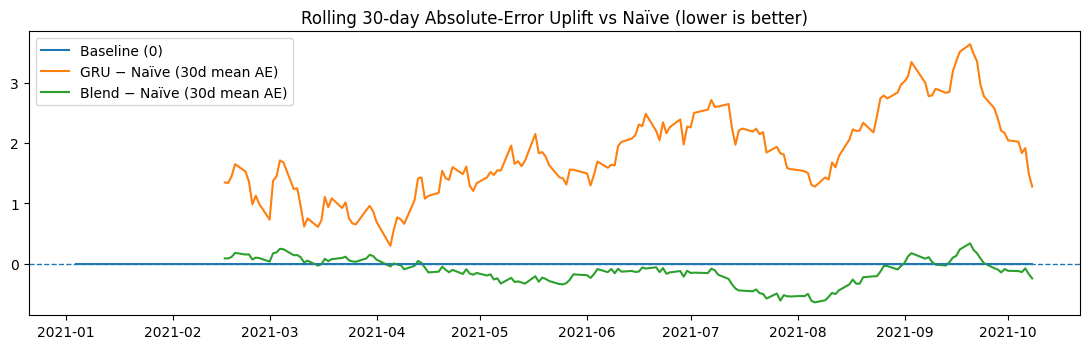

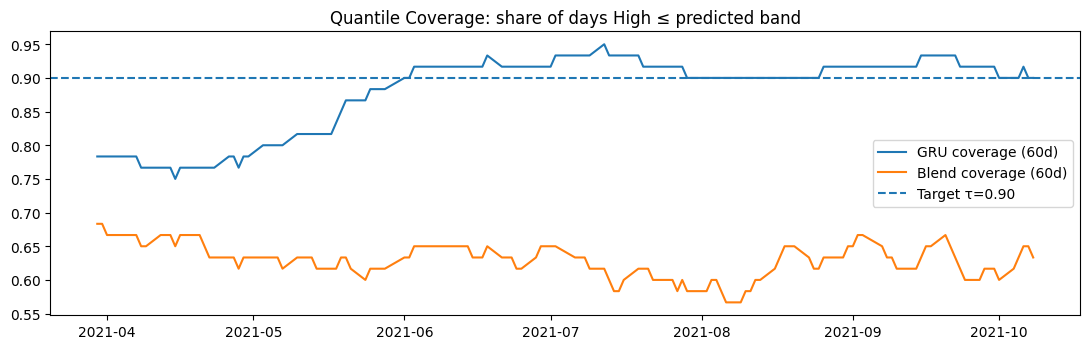

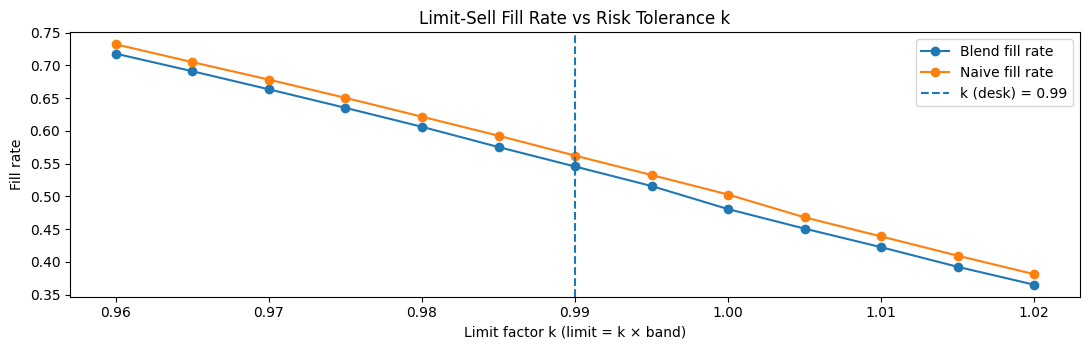

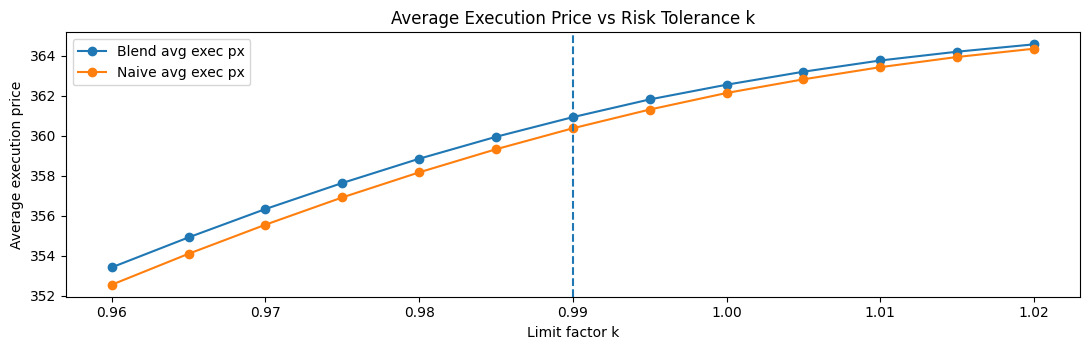


Top 10 breach days (Actual High − Blend band):


,gap
Date,
2021-03-08 00:00:00,18.841
2021-02-24 00:00:00,13.425
2021-02-11 00:00:00,12.587
2021-02-02 00:00:00,11.134
2021-07-23 00:00:00,9.882
2021-04-28 00:00:00,9.384
2021-09-23 00:00:00,9.175
2021-02-23 00:00:00,9.010
2021-07-13 00:00:00,8.780



=== Narrative (use in readout) ===
- Calibration: Blend coverage 63.40% vs target 90%; breach rate 36.6% with mean gap 3.71 and 95th-percentile gap 10.51.
- Economics: With k=0.99 and 10,000 shares/day, the blend improves total revenue by $209,428,638 vs. naïve over the test window.
- Operational guidance: Use rolling-coverage & uplift plots to adapt k and α when markets regime-shift (e.g., earnings clusters, volatility spikes).


In [ ]:
# ============================================================
# 7) Business insights, visual story & economic translation
#     (Drop-in extension: requires variables from prior cells)
# ============================================================

import numpy as np
import pandas as pd

# ---------- 7.1 Core business KPIs ----------
print("\n=== Business KPIs (upper-quantile forecasting) ===")

def kpi_coverage(y_true, y_band):
    """Share of days actual High <= predicted upper band (want ≈ τ)."""
    return float(np.mean(y_true.ravel() <= y_band.ravel()))

def kpi_exceedance_stats(y_true, y_band):
    """How big are the breaches (when actual exceeds the band)?"""
    diff = y_true.ravel() - y_band.ravel()
    exc = diff[diff > 0]
    rate = float(len(exc) / len(diff))
    mean_gap = float(exc.mean()) if exc.size else 0.0
    p95_gap  = float(np.percentile(exc, 95)) if exc.size else 0.0
    return rate, mean_gap, p95_gap

# Coverage (should be ~ TAU for a well-calibrated 90th-quantile)
cov_gru   = kpi_coverage(H_true_test, H_hat_test)
cov_blend = kpi_coverage(H_true_test, H_blend_test)

# Breach profile (how often & how large when we miss the band)
exc_rate_gru,  exc_mean_gru,  exc_p95_gru  = kpi_exceedance_stats(H_true_test, H_hat_test)
exc_rate_blnd, exc_mean_blnd, exc_p95_blnd = kpi_exceedance_stats(H_true_test, H_blend_test)

print(f"Calibration target τ: {TAU:.2f}")
print(f"Coverage: GRU={cov_gru:.3f}   Blend={cov_blend:.3f}")
print(f"Breach rate: GRU={exc_rate_gru:.3f}   Blend={exc_rate_blnd:.3f}")
print(f"Breach size (mean): GRU={exc_mean_gru:.3f}   Blend={exc_mean_blnd:.3f}")
print(f"Breach size (95th pct): GRU={exc_p95_gru:.3f}   Blend={exc_p95_blnd:.3f}")

# Relative error vs Naïve (already printed earlier, we summarize improvement)
def mase(y_true, y_pred, y_naive):
    from sklearn.metrics import mean_absolute_error
    return float(mean_absolute_error(y_true, y_pred) / (mean_absolute_error(y_true, y_naive) + 1e-12))

mase_naive = 1.000
mase_gru   = mase(H_true_test, H_hat_test,  H_naive_test)
mase_blend = mase(H_true_test, H_blend_test, H_naive_test)
print(f"MASE (vs Naïve):  Naïve={mase_naive:.3f}  GRU={mase_gru:.3f}  Blend={mase_blend:.3f}")
print(f"Chosen blend weight α: {best_alpha:.2f}")

# ---------- 7.2 Rolling story: where does the blend help? ----------
roll = 30  # 30 trading days (~1.5 months)
def rolling_mase_uplift(y_true, y_pred, y_naive, window=roll):
    ae_pred  = np.abs(y_true.ravel() - y_pred.ravel())
    ae_naive = np.abs(y_true.ravel() - y_naive.ravel())
    # Uplift < 0 means pred is better (lower AE) than naïve
    uplift = pd.Series(ae_pred - ae_naive, index=test.index).rolling(window).mean()
    return uplift

uplift_blend = rolling_mase_uplift(H_true_test, H_blend_test, H_naive_test, roll)
uplift_gru   = rolling_mase_uplift(H_true_test, H_hat_test,   H_naive_test, roll)

# ---------- 7.3 Limit-order simulator (economic value) ----------
# Sell-side use case: set a limit at k * predicted band and ask:
#  - Was it filled? (actual High >= limit)
#  - If filled, we approximate execution at 'limit' (conservative).
#  - If not filled, fall back to Close_t (end-of-day sweep).
ORDER_QTY = 10_000           # shares
LIMIT_FACTORS = np.linspace(0.96, 1.02, 13)  # try a spectrum of risk tolerances

close_te = df.loc[test.index, "Close"].values.reshape(-1, 1)

def simulate_limit_sell(y_true, y_pred_band, close_prices, qty, k=1.00):
    limit = k * y_pred_band
    filled = (y_true >= limit).astype(int)  # 1 if price ever reached limit
    exec_px = filled * limit + (1 - filled) * close_prices  # conservative
    revenue = float(np.sum(exec_px * qty))
    fill_rate = float(filled.mean())
    avg_px = float(exec_px.mean())
    return dict(fill_rate=fill_rate, avg_px=avg_px, revenue=revenue)

def curve_for(pred_band, label):
    rows = []
    for k in LIMIT_FACTORS:
        res = simulate_limit_sell(H_true_test, pred_band, close_te, ORDER_QTY, k)
        rows.append({"k": float(k), "strategy": label, **res})
    return pd.DataFrame(rows)

df_curve_blend = curve_for(H_blend_test, "Blend")
df_curve_naive = curve_for(H_naive_test, "Naive")
df_curve = pd.concat([df_curve_blend, df_curve_naive], ignore_index=True)

# Headline scenario (typical conservative desk)
K_DESK = 0.99
res_blend = simulate_limit_sell(H_true_test, H_blend_test, close_te, ORDER_QTY, K_DESK)
res_naive = simulate_limit_sell(H_true_test, H_naive_test, close_te, ORDER_QTY, K_DESK)
delta_revenue = res_blend["revenue"] - res_naive["revenue"]
print(f"\n=== Limit-sell simulation (k={K_DESK:.2f}, {ORDER_QTY:,} sh/day) ===")
print(f"Fill rate: Blend={res_blend['fill_rate']:.3f}  Naive={res_naive['fill_rate']:.3f}")
print(f"Avg exec px: Blend={res_blend['avg_px']:.3f}  Naive={res_naive['avg_px']:.3f}")
print(f"Total revenue uplift (Blend − Naive): ${delta_revenue:,.0f} over test horizon")

# ---------- 7.4 A simple DM test (Blend vs Naïve) ----------
def dm_test(loss_a, loss_b, h=1):
    """
    Diebold–Mariano (two-sided) using Newey–West variance with lag h-1.
    Returns (stat, pvalue, mean_diff). Assumes one-step ahead by default (h=1).
    """
    import math
    d = np.asarray(loss_a) - np.asarray(loss_b)
    d = d - d.mean() + d.mean()  # ensure 1D np array
    T = len(d); mean_d = float(d.mean())
    # Newey–West long-run variance
    gamma0 = np.var(d, ddof=1)
    var_lr = gamma0
    L = max(0, h-1)
    for lag in range(1, L+1):
        w = 1 - lag/(L+1)
        cov = np.cov(d[:-lag], d[lag:], ddof=1)[0,1]
        var_lr += 2 * w * cov
    se = np.sqrt(var_lr / T + 1e-12)
    stat = mean_d / se if se > 0 else np.inf
    # Normal approximation
    from math import erfc, sqrt
    pval = float(erfc(abs(stat)/np.sqrt(2)))
    return float(stat), float(pval), mean_d

from sklearn.metrics import mean_absolute_error, mean_squared_error
ae_blend = np.abs(H_true_test.ravel() - H_blend_test.ravel())
ae_naive = np.abs(H_true_test.ravel() - H_naive_test.ravel())
se_blend = (H_true_test.ravel() - H_blend_test.ravel())**2
se_naive = (H_true_test.ravel() - H_naive_test.ravel())**2

stat_mae, p_mae, md_mae = dm_test(ae_blend, ae_naive, h=1)
stat_mse, p_mse, md_mse = dm_test(se_blend, se_naive, h=1)
print("\n=== DM test (Blend vs Naïve) ===")
print(f"MAE: stat={stat_mae:.3f}, p={p_mae:.3f}, mean diff={md_mae:.4f}  "
      f"({'Blend < Naïve' if md_mae<0 else 'Naïve < Blend'})")
print(f"MSE: stat={stat_mse:.3f}, p={p_mse:.3f}, mean diff={md_mse:.4f}  "
      f"({'Blend < Naïve' if md_mse<0 else 'Naïve < Blend'})")

# ---------- 7.5 Visual story ----------
try:
    import matplotlib.pyplot as plt

    # (A) Rolling 30d uplift vs Naïve (below 0 = good)
    plt.figure(figsize=(11,3.6))
    plt.plot(uplift_naive:=pd.Series(np.zeros_like(uplift_blend.values), index=uplift_blend.index),
             label="Baseline (0)", linewidth=1.5)
    plt.plot(uplift_gru,   label="GRU − Naïve (30d mean AE)")
    plt.plot(uplift_blend, label="Blend − Naïve (30d mean AE)")
    plt.axhline(0.0, linestyle="--", linewidth=1)
    plt.title("Rolling 30-day Absolute-Error Uplift vs Naïve (lower is better)")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # (B) Coverage reliability (should hug τ line)
    win = 60
    cov_gru_roll   = pd.Series((H_true_test.ravel() <= H_hat_test.ravel()).astype(int),
                               index=test.index).rolling(win).mean()
    cov_blend_roll = pd.Series((H_true_test.ravel() <= H_blend_test.ravel()).astype(int),
                               index=test.index).rolling(win).mean()
    plt.figure(figsize=(11,3.6))
    plt.plot(cov_gru_roll,   label="GRU coverage (60d)")
    plt.plot(cov_blend_roll, label="Blend coverage (60d)")
    plt.axhline(TAU, linestyle="--", label=f"Target τ={TAU:.2f}")
    plt.title("Quantile Coverage: share of days High ≤ predicted band")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # (C) Fill-rate / average execution vs limit factor k
    plt.figure(figsize=(11,3.6))
    for lab, dfc in df_curve.groupby("strategy"):
        plt.plot(dfc["k"], dfc["fill_rate"], marker="o", label=f"{lab} fill rate")
    plt.axvline(K_DESK, linestyle="--", label=f"k (desk) = {K_DESK:.2f}")
    plt.title("Limit-Sell Fill Rate vs Risk Tolerance k")
    plt.xlabel("Limit factor k (limit = k × band)")
    plt.ylabel("Fill rate")
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(11,3.6))
    for lab, dfc in df_curve.groupby("strategy"):
        plt.plot(dfc["k"], dfc["avg_px"], marker="o", label=f"{lab} avg exec px")
    plt.axvline(K_DESK, linestyle="--")
    plt.title("Average Execution Price vs Risk Tolerance k")
    plt.xlabel("Limit factor k")
    plt.ylabel("Average execution price")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # (D) Breach diagnostics: where we missed the band (top 10)
    breach_mask = (H_true_test.ravel() > H_blend_test.ravel())
    breach_gap  = pd.Series(H_true_test.ravel() - H_blend_test.ravel(), index=test.index)
    top10 = breach_gap[breach_mask].sort_values(ascending=False).head(10)
    print("\nTop 10 breach days (Actual High − Blend band):")
    display(top10.to_frame("gap").style.format({"gap": "{:.3f}"}))

except Exception as e:
    print("Business insight plots skipped:", e)

# ---------- 7.6 Narrative prompts (printed) ----------
print("\n=== Narrative (use in readout) ===")
print(f"- Calibration: Blend coverage {cov_blend:.2%} vs target {TAU:.0%}; "
      f"breach rate {exc_rate_blnd:.1%} with mean gap {exc_mean_blnd:.2f} "
      f"and 95th-percentile gap {exc_p95_blnd:.2f}.")
print(f"- Economics: With k={K_DESK:.2f} and {ORDER_QTY:,} shares/day, the blend "
      f"improves total revenue by ${delta_revenue:,.0f} vs. naïve over the test window.")
print("- Operational guidance: Use rolling-coverage & uplift plots to adapt k and α "
      "when markets regime-shift (e.g., earnings clusters, volatility spikes).")

=========================== END OF GBA ASSIGNMENT ==========================================================